# Analysis of the housing market for first-time buyers in Ireland

In [40]:
# Library imports

# For data retrieval
from pyjstat import pyjstat

# Data manipulation and analysis
import pandas as pd
import numpy as np
import geopandas as gpd # For geo–spatial data 

# Visualisations
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline
from IPython.core.display import HTML


# Data Identifiation and Collection

I decided to look at the housing market for first-time buyers, more specifically in Dublin. I used the datasets available at https://data.cso.ie/, combining a few different datasets such as property sales data, annual earnings data, and new house registrations. 

The datasets I used:
* [Market-based Household Purchases of Residential Dwellings](https://data.cso.ie/table/HPA04)
* [Mean and Median Annual Earnings](https://data.cso.ie/table/NEA08)
* [New Dwelling Completions](https://data.cso.ie/table/NDA01)


The CSO uses a JSON format called JSON-stat to distribute their data, which is a public standard for data dissemination. More details available here: https://json-stat.org/

To parse this data, I used a library called [pyjstat](https://pypi.org/project/pyjstat/). This enables me to go from JSON-stat -> to Pandas Dataframe and vice versa in one step. I have saved the datasets in their JSON-stat format, which is still readable in a text editor, and I work with them here through pyjstat.

I used the below code to retrieve the data from the CSO AP and write it to JSON files locally. These are already available in the `data` folder and do not need to be ran again.

In [2]:
# Get the data from the API
property_sale_data_raw = pyjstat.Dataset.read('https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/HPA04/JSON-stat/2.0/en')

# Write to local JSON file
with open("data/property_sale_data.json", "w") as f:
    f.write(property_sale_data_raw.write('jsonstat'))


In [3]:
# Get data from the API
annual_earnings_raw = pyjstat.Dataset.read('https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/NEA08/JSON-stat/2.0/en')  

# Write to file
with open("data/annual_earnings_data.json", "w") as f:
    f.write(annual_earnings_raw.write('jsonstat'))


In [4]:
# Get data from the API
housing_completions_raw = pyjstat.Dataset.read('https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/NDA01/JSON-stat/2.0/en')

# Write JSON to file
with open("data/housing_completions_data.json", "w") as f:
    f.write(housing_completions_raw.write('jsonstat'))


# Data preparation and analysis

As I used 3 different datasets for various analysis, each was prepared slightly differently. I 

## Property sales data

This data set includes a lot of different data about house sales in each year in an Eircode region. For example it includes the Volume of Sales, the mean sale price, the median sale price, and the buyer type.

In [5]:
# Read data from file
with open("data/property_sale_data.json", "r") as f:
    property_sale_data_raw = pyjstat.Dataset.read(f)

property_sale_data = property_sale_data_raw.write('dataframe')
property_sale_data.head()    

Statistic  Year        Dwelling Status Eircode Output  \
0  Volume of Sales  2010  All Dwelling Statuses            All   
1  Volume of Sales  2010  All Dwelling Statuses            All   
2  Volume of Sales  2010  All Dwelling Statuses            All   
3  Volume of Sales  2010  All Dwelling Statuses            All   
4  Volume of Sales  2010  All Dwelling Statuses            All   

  Stamp Duty Event                                      Type of Buyer    value  
0          Filings                                    All Buyer Types  19302.0  
1          Filings  Household Buyer - First-Time Buyer Owner-Occupier  10434.0  
2          Filings            Household Buyer - Former Owner-Occupier   6237.0  
3          Filings                     Household Buyer - Non-Occupier   2631.0  
4       Executions                                    All Buyer Types  17933.0

### Prepare property prices dataset:
 * Take the median price, mean price will be skewed by high value property. There is infinite upside to house prices but limited downside
 * Take all dwellings (new build and existing) as we are interested in seeing housing affordability in general
 * I went with Stamp Duty Executions, once we are consistent in our choice else where it shouldn't matter which we pick.
 * Type of buyer is first time buyer, as this is who we are interested in
 
We then drop the columns we have filtered by, as they contain only one value anyways. We leave this data frame as a simple table as later on we need to further filter the data by the Eircode.

In [6]:
property_sale_prices = property_sale_data[
    (property_sale_data['Statistic'] == 'Median Price') &
    (property_sale_data['Dwelling Status'] == 'All Dwelling Statuses') &
    (property_sale_data['Stamp Duty Event'] == 'Executions') &
    (property_sale_data['Eircode Output'] != 'All') &
    (property_sale_data['Type of Buyer'] == 'Household Buyer - First-Time Buyer Owner-Occupier')] \
.drop(['Stamp Duty Event', 'Type of Buyer', 'Dwelling Status', 'Statistic'], axis=1)

property_sale_prices.rename(columns={'value': 'Median property value'}, inplace=True)

# Show sample of dataframe
property_sale_prices.head()


Year     Eircode Output  Median property value
110893  2010  A41: Ballyboughal               237000.0
110901  2010    A42: Garristown               314650.0
110909  2010       A45: Oldtown               247430.0
110917  2010    A63: Greystones               295100.0
110925  2010       A67: Wicklow               290050.0

In [7]:
# I deal with these NA values later, I use this data in a few places and it's simpler to leave this table as-is for now
property_sale_prices.isna().sum() 

Year                     0
Eircode Output           0
Median property value    6
dtype: int64

### Prepare property sale volume dataset:

We have data on the median property sale prices, but we also need data on the volume of property sold to first-time buyers in a given Eircode.

In [8]:
property_sale_volumes = property_sale_data[
    (property_sale_data['Statistic'] == 'Volume of Sales') &
    (property_sale_data['Dwelling Status'] == 'All Dwelling Statuses') &
    (property_sale_data['Type of Buyer'] == 'Household Buyer - First-Time Buyer Owner-Occupier') &
    (property_sale_data['Stamp Duty Event'] == 'Executions') &
    (property_sale_data['Eircode Output'] != 'All')
]
property_sale_volumes = property_sale_volumes.drop(['Dwelling Status', 'Stamp Duty Event'], axis=1)
property_sale_volumes['Eircode Output'] = property_sale_volumes['Eircode Output'].str[:3] # Drop the descriptor as we don't need it
property_sale_volumes = property_sale_volumes.pivot(index='Eircode Output', columns='Year', values='value')
property_sale_volumes.head()

Year             2010  2011  2012  2013  2014  2015   2016   2017   2018  \
Eircode Output                                                             
A41               1.0   3.0   0.0   3.0   0.0   0.0    7.0    5.0    2.0   
A42               2.0   4.0   3.0   4.0   4.0   2.0    0.0    4.0    4.0   
A45               4.0   4.0   2.0   1.0   3.0   2.0    1.0    5.0    2.0   
A63             107.0  41.0  67.0  47.0  67.0  87.0  115.0  182.0  155.0   
A67              42.0  20.0  34.0  38.0  40.0  63.0   52.0   85.0   92.0   

Year             2019   2020  
Eircode Output                
A41               9.0    4.0  
A42               7.0    6.0  
A45               1.0    1.0  
A63             221.0  145.0  
A67             161.0  158.0

In [9]:
property_sale_volumes.isna().sum() # Nothing to fix here

Year
2010    0
2011    0
2012    0
2013    0
2014    0
2015    0
2016    0
2017    0
2018    0
2019    0
2020    0
dtype: int64

## Earnings data

I used earnings data broken down by county in measuring housing affordability. The dataset contains the data broken down by sex and median / mean earnings. To account for high earners skewing the data, I went with the median earning data.

In [10]:
# Read from file
with open("data/annual_earnings_data.json", "r") as f:
    annual_earnings_raw = pyjstat.Dataset.read(f)

In [11]:
annual_earnings = annual_earnings_raw.write('dataframe')

# Filter by both sexes and median annual earnings to account for skew caused by high earners
# Then drop filtered columns they're redundant
annual_earnings = annual_earnings[
                        (annual_earnings['Sex'] == 'Both sexes') &
                        (annual_earnings['Statistic'] == 'Median Annual Earnings')
                    ].drop(['Statistic', 'Sex'], axis=1)
annual_earnings.head()

Year            County    value
648  2011  All counties (1)  33300.0
651  2011            Carlow  30719.0
654  2011            Dublin  35915.0
657  2011           Kildare  35795.0
660  2011          Kilkenny  32098.0

In [12]:
annual_earnings.isna().sum() # Also nothing to fix here

Year      0
County    0
value     0
dtype: int64

## Housing completion data

Housing completion data is broken down by Eircode and year. We take out the rolled up Eircode ('All'), trim the Eircode and pivot the table to display it indexed by Eircode.

In [13]:
# Read raw data from JSON file
with open("data/housing_completions_data.json", "r") as f:
    housing_completions_raw = pyjstat.Dataset.read(f)


In [14]:
housing_completions = housing_completions_raw.write('dataframe').drop('Statistic', axis=1)
housing_completions = housing_completions[housing_completions['Eircode Output'] != 'All']
housing_completions['Eircode Output'] = housing_completions['Eircode Output'].str[:3]
housing_completions = housing_completions.pivot(index='Eircode Output', columns=['Year'], values='value')

housing_completions.head()

Year            2012  2013  2014   2015   2016   2017   2018   2019   2020
Eircode Output                                                            
A41              5.0  16.0   4.0    4.0   27.0   14.0   20.0   48.0   32.0
A42             11.0   4.0   2.0    4.0   11.0    5.0   12.0   12.0   13.0
A45              1.0   1.0   2.0    1.0    2.0    1.0    3.0    5.0    3.0
A63             50.0  31.0  29.0  107.0  179.0  250.0  288.0  465.0  333.0
A67             23.0  19.0  30.0   80.0   68.0   95.0  168.0  450.0  373.0

In [15]:
housing_completions.isna().sum() # All good too

Year
2012    0
2013    0
2014    0
2015    0
2016    0
2017    0
2018    0
2019    0
2020    0
dtype: int64

## Eircode boundaries

To create heatmaps as part of the analysis, I needed some data about Eircode boundaries. To do this I used the ESRI Shape file provided on this page: https://www.autoaddress.ie/support/developer-centre/resources/routing-key-boundaries

AutoAddress.ie is the company behind the Eircode system. They provide the Shape file openly and for free. Using this Shape file in conjunction with GeoPandas and Matplotlib we can easily visualise geo-spatial data.   

In [41]:
# Eircode map data
shapefile = 'data/shp_files/RoutingKeys_region.shp'
eircode_gdf = gpd.read_file(shapefile)
eircode_gdf.index = eircode_gdf['RoutingKey']
eircode_gdf = eircode_gdf.drop('RoutingKey', axis=1)
eircode_gdf.head() # Example table

Descriptor                                           geometry
RoutingKey                                                                 
A41         BALLYBOUGHAL  POLYGON Z ((315955.386 256978.846 0.000, 31648...
A45              OLDTOWN  POLYGON Z ((314571.090 253236.195 0.000, 31454...
A67              WICKLOW  POLYGON Z ((334558.591 192357.530 0.000, 33452...
A83              ENFIELD  POLYGON Z ((289532.317 249779.205 0.000, 28942...
A91              DUNDALK  POLYGON Z ((288753.376 303794.647 0.000, 28886...

## Data preparation summary

There are 4 distinct datasets:
* Median property sale price to first-time buyers
* Property sale volume to first-time buyers
* Housing completion numbers
* Median earnings

Additionally, I use an Eircode mapping dataset to add to our visualisations.

In [42]:
property_sale_prices.head()

Year     Eircode Output  Median property value
110893  2010  A41: Ballyboughal               237000.0
110901  2010    A42: Garristown               314650.0
110909  2010       A45: Oldtown               247430.0
110917  2010    A63: Greystones               295100.0
110925  2010       A67: Wicklow               290050.0

In [43]:
property_sale_volumes.head()

Year             2010  2011  2012  2013  2014  2015   2016   2017   2018  \
Eircode Output                                                             
A41               1.0   3.0   0.0   3.0   0.0   0.0    7.0    5.0    2.0   
A42               2.0   4.0   3.0   4.0   4.0   2.0    0.0    4.0    4.0   
A45               4.0   4.0   2.0   1.0   3.0   2.0    1.0    5.0    2.0   
A63             107.0  41.0  67.0  47.0  67.0  87.0  115.0  182.0  155.0   
A67              42.0  20.0  34.0  38.0  40.0  63.0   52.0   85.0   92.0   

Year             2019   2020  
Eircode Output                
A41               9.0    4.0  
A42               7.0    6.0  
A45               1.0    1.0  
A63             221.0  145.0  
A67             161.0  158.0

In [44]:
housing_completions.head()

Year            2012  2013  2014   2015   2016   2017   2018   2019   2020
Eircode Output                                                            
A41              5.0  16.0   4.0    4.0   27.0   14.0   20.0   48.0   32.0
A42             11.0   4.0   2.0    4.0   11.0    5.0   12.0   12.0   13.0
A45              1.0   1.0   2.0    1.0    2.0    1.0    3.0    5.0    3.0
A63             50.0  31.0  29.0  107.0  179.0  250.0  288.0  465.0  333.0
A67             23.0  19.0  30.0   80.0   68.0   95.0  168.0  450.0  373.0

In [45]:
annual_earnings.head()

Year            County    value
648  2011  All counties (1)  33300.0
651  2011            Carlow  30719.0
654  2011            Dublin  35915.0
657  2011           Kildare  35795.0
660  2011          Kilkenny  32098.0

In [46]:
eircode_gdf.head()

Descriptor                                           geometry
RoutingKey                                                                 
A41         BALLYBOUGHAL  POLYGON Z ((315955.386 256978.846 0.000, 31648...
A45              OLDTOWN  POLYGON Z ((314571.090 253236.195 0.000, 31454...
A67              WICKLOW  POLYGON Z ((334558.591 192357.530 0.000, 33452...
A83              ENFIELD  POLYGON Z ((289532.317 249779.205 0.000, 28942...
A91              DUNDALK  POLYGON Z ((288753.376 303794.647 0.000, 28886...

# Property prices vs mortgage buying power

In 2015, the Central Bank introduced a set of mortgage restrictions. These restrictions are aimed to prevent people borrowing more than they can afford and ensure the stability of the financial system in light of the 2008 financial crisis. These restrictions include Loan-to-Value and Loan-to-Income limits – essentially mandating minimum deposit amounts and maximum loan values.

I will cover the key points of the limits for this analysis, but more details can be found here: https://www.centralbank.ie/consumer-hub/explainers/what-are-the-mortgage-measures 

The key part of these restrictions for our analysis is the Loan-to-Income limit, which restricts the amount of money you can borrow to 3.5x your gross annual income. This isn't a hard limit on what house you can buy, as you can save for a larger deposit and therefore take a smaller mortgage, but looking at house prices in relation to this 3.5x limit is a useful indicator for the health and affordability of housing the market. The 3.5x limit doesn't vary depending on the cost of the property either, it's only variable is the persons income.

Although it isn't a hard limit on the property value per se, saving for a larger deposit could take years for those who cannot cut costs as other do, such as by moving back in with their parents. The fact such cost cutting measures would even be required are indications of a housing market that is of questionable affordability.

Banks do have some flexibilty in their lending. For up to 20% of their mortgage values for first time buyers, they can lend up to 4.5x their income. This is generally given to those in higher paid, secure jobs and therefore not something the median borrow will be given, but looking at prices vs this upper limit is also useful to gauge where the market is at.

## Earnings and mortgage buying power data preparation

Based on the above lending limits (3.5x gross income, up to 4.5x for a small number of borrowers), we will calculate the borrowing potential for individuals and couples based on the median income in different counties. This gives us some ball park figures to gauge housing affordability – while the 4.5x limit is only given to a small number of borrowers, we can use it as a reference to account for those who have saved for a larger deposit. If house prices are pushing the upper limit, this is a pretty strong indicator that it is becoming or is unaffordable for those only allowed borrow 3.5x their income – the majority of people. 

In [47]:
# Function to filter earnings data by a given county and calculate mortgage borrowing potential
def prepare_earnings_data(earnings_df, county):
    earnings_median_county = earnings_df[earnings_df['County'] ==  county]
    earnings_median_county.index = earnings_median_county['Year']
    
    # Drop the county column as it's redundant
    earnings_median_county = earnings_median_county.drop(['Year','County'], axis=1)
    earnings_median_county.rename(columns={'value': 'Median Earnings'}, inplace=True)
    
    # Calculate mortgage potentials for individuals and couples
    earnings_median_county['Individual mortgage – 3.5x'] = earnings_median_county['Median Earnings']*3.5
    earnings_median_county['Individual mortgage – 4.5x'] = earnings_median_county['Median Earnings']*4.5
    earnings_median_county['Couple mortgage – 3.5x'] = earnings_median_county['Median Earnings']*3.5*2
    earnings_median_county['Couple mortgage – 4.5x'] = earnings_median_county['Median Earnings']*4.5*2
    return earnings_median_county

In [48]:
annual_earnings_median_dublin = prepare_earnings_data(annual_earnings, 'Dublin')
annual_earnings_median_dublin # Example dataframe

Median Earnings  Individual mortgage – 3.5x  Individual mortgage – 4.5x  \
Year                                                                            
2011          35915.0                    125702.5                    161617.5   
2012          35775.0                    125212.5                    160987.5   
2013          35930.0                    125755.0                    161685.0   
2014          36129.0                    126451.5                    162580.5   
2015          36416.0                    127456.0                    163872.0   
2016          37084.0                    129794.0                    166878.0   
2017          38067.0                    133234.5                    171301.5   
2018          39408.0                    137928.0                    177336.0   

      Couple mortgage – 3.5x  Couple mortgage – 4.5x  
Year                                                  
2011                251405.0                323235.0  
2012                250425.0                321975.0  
2013                251510.0                323370.0  
2014                252903.0                325161.0  
2015                254912.0                327744.0  
2016                259588.0                333756.0  
2017                266469.0                342603.0  
2018                275856.0                354672.0

In [49]:
annual_earnings_median_galway = prepare_earnings_data(annual_earnings, 'Galway')

In [26]:
annual_earnings_median_cork = prepare_earnings_data(annual_earnings, 'Cork')

## Property sale data preparation

We will calculate property price data from the sale value for property in different Eircode regions. This involves filtering the dataset by Eircode as the median price is already provided.

In the case we have filtered for multiple Eircodes, such as when we filter for all the Dublin Eircodes, we will take the median value.

In [27]:
def filter_property_sale_prices(prices_df, eircode_filter):
    # Filter by Eircode, (e.g. contains Dublin for all Dublin Eircodes (Dublin 1, Dublin 2, etc))
    # Or 'Galway' for the 'Galway' Eircode
    prices_df_filter = prices_df[prices_df['Eircode Output'].str.contains(eircode_filter)]
    
    # If there are multiple regions (e.g.Dublin 1, Dublin 2, etc), group by year and take the median
    prices_df_filter_yearly = prices_df_filter.groupby('Year').median()
    
    return prices_df_filter_yearly

In [28]:
property_sale_prices_dublin_median_yearly = filter_property_sale_prices(property_sale_prices, 'Dublin')
property_sale_prices_dublin_median_yearly # Example output

Median property value
Year                       
2010               253844.0
2011               215000.0
2012               195000.0
2013               185750.0
2014               248875.0
2015               275000.0
2016               298000.0
2017               321996.0
2018               350181.0
2019               347500.0
2020               350000.0

In [29]:
property_sale_prices_galway_median_yearly = filter_property_sale_prices(property_sale_prices, 'Galway')


In [30]:
property_sale_prices_cork_median_yearly = filter_property_sale_prices(property_sale_prices, 'Cork')


## Mortgage borrowing potential vs house price analysis

We join the property price data with the earnings and estimated mortgage data we have prepared.

There is no earnings data for 2010, 2019, or 2020. I chose not to fill these blanks with any estimations or projections as it is still possible to interpret the graphs with this information missing. Additionally with the unprecedented situation occuring in 2020 I did not think it would be accurate to create a projection for this data.

I created plots for 3 urban regions – Dublin, Galway, and Cork. The earnings data is at a county level vs an Eircode level, therefore I would expect our salary data to skew on the low side for Cork and Galway as they have much a larger proportion of rural communities. Dublin is mostly urban, therefore I expect the county level salary data to be more representative of that population. We can use these visualisations to compare across regions, taking into account potential compounding factors.

The graphs are displayed below, with discussion afterwards.

### Dublin

In [31]:
# Join the property price data with annual earnings data
property_v_earnings_dub = property_sale_prices_dublin_median_yearly.join(annual_earnings_median_dublin)
property_v_earnings_dub # Example of what the dataframe looks like

Median property value  Median Earnings  Individual mortgage – 3.5x  \
Year                                                                       
2010               253844.0              NaN                         NaN   
2011               215000.0          35915.0                    125702.5   
2012               195000.0          35775.0                    125212.5   
2013               185750.0          35930.0                    125755.0   
2014               248875.0          36129.0                    126451.5   
2015               275000.0          36416.0                    127456.0   
2016               298000.0          37084.0                    129794.0   
2017               321996.0          38067.0                    133234.5   
2018               350181.0          39408.0                    137928.0   
2019               347500.0              NaN                         NaN   
2020               350000.0              NaN                         NaN   

      Individual mortgage – 4.5x  Couple mortgage – 3.5x  \
Year                                                       
2010                         NaN                     NaN   
2011                    161617.5                251405.0   
2012                    160987.5                250425.0   
2013                    161685.0                251510.0   
2014                    162580.5                252903.0   
2015                    163872.0                254912.0   
2016                    166878.0                259588.0   
2017                    171301.5                266469.0   
2018                    177336.0                275856.0   
2019                         NaN                     NaN   
2020                         NaN                     NaN   

      Couple mortgage – 4.5x  
Year                          
2010                     NaN  
2011                323235.0  
2012                321975.0  
2013                323370.0  
2014                325161.0  
2015                327744.0  
2016                333756.0  
2017                342603.0  
2018                354672.0  
2019                     NaN  
2020                     NaN

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


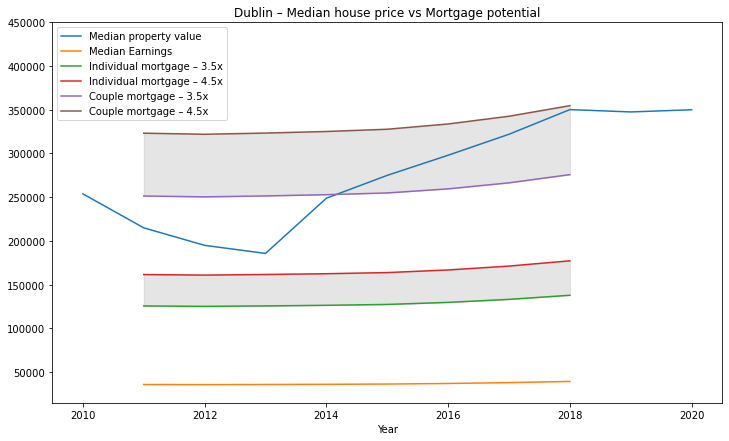

In [32]:
# Plot property prices against earnings and potential mortgage values
property_v_earnings_dub.plot(figsize=(12,7), ylim=(15000, 450000))
plt.title("Dublin – Median house price vs Mortgage potential")
plt.fill_between(property_v_earnings_dub.index, property_v_earnings_dub['Individual mortgage – 3.5x'], property_v_earnings_dub['Individual mortgage – 4.5x'], alpha=0.2, color='grey')
plt.fill_between(property_v_earnings_dub.index, property_v_earnings_dub['Couple mortgage – 3.5x'], property_v_earnings_dub['Couple mortgage – 4.5x'], alpha=0.2, color='grey')
# This cell generates warnings which can be ignored as they are warning of expected behaviour


### Galway

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


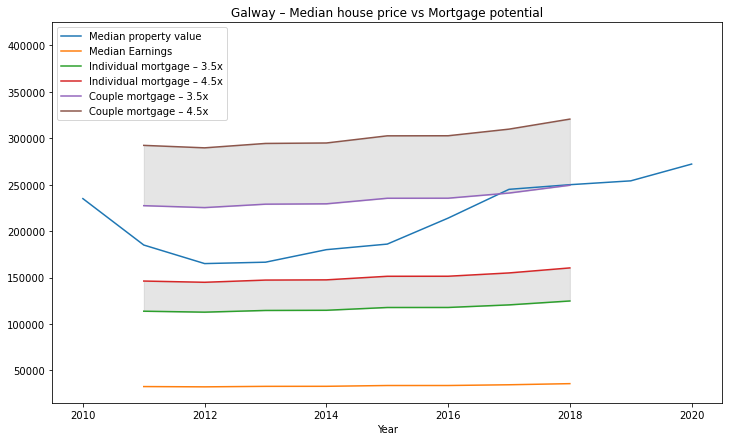

In [33]:
prop_v_earnings_gal = property_sale_prices_galway_median_yearly.join(annual_earnings_median_galway)
prop_v_earnings_gal.plot(figsize=(12,7), ylim=(15000, 425000))
plt.title("Galway – Median house price vs Mortgage potential")
plt.fill_between(prop_v_earnings_gal.index, prop_v_earnings_gal['Individual mortgage – 3.5x'], prop_v_earnings_gal['Individual mortgage – 4.5x'], alpha=0.2, color='grey')
plt.fill_between(prop_v_earnings_gal.index, prop_v_earnings_gal['Couple mortgage – 3.5x'], prop_v_earnings_gal['Couple mortgage – 4.5x'], alpha=0.2, color='grey')
# This cell generates warnings which can be ignored as they are warning of expected behaviour


### Cork

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


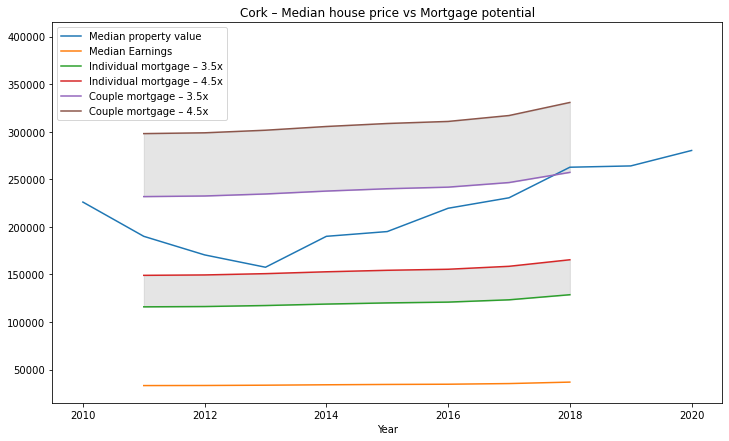

In [34]:
prop_v_earnings_cork = property_sale_prices_cork_median_yearly.join(annual_earnings_median_cork)
prop_v_earnings_cork.plot(figsize=(12,7), ylim=(15000, 415000))
plt.title("Cork – Median house price vs Mortgage potential")
plt.fill_between(prop_v_earnings_cork.index, prop_v_earnings_cork['Individual mortgage – 3.5x'], prop_v_earnings_cork['Individual mortgage – 4.5x'], alpha=0.2, color='grey')
plt.fill_between(prop_v_earnings_cork.index, prop_v_earnings_cork['Couple mortgage – 3.5x'], prop_v_earnings_cork['Couple mortgage – 4.5x'], alpha=0.2, color='grey')
# This cell generates warnings which can be ignored as they are warning of expected behaviour


### Discussion

The graphs above show the median house prices in each region in the blue line. The yellow line at the bottom is the earings, and the lines with grey bands filled in between are the potential mortgage values for individuals and couples.

We can see clearly that the median property price in every region is far exceeding potential mortgage values for individuals with a standard deposit. Individuals would require deposits of over €100,000 to purchase a median priced house, assuming they received a mortgage with the higher limit. It's clear to say individuals are largely priced out of the median priced housing market, considering the savings required are over 3 years of their full gross income. Factoring in cost of living and taxes, this could take an excessive length of time to save for.

Dublin is the only region where the median property price has reached the higher band potential mortgage for couples. This indicates Dublin house values are pushing what local median earners can afford to an extreme level, and in fact implies that it's already pricing out the majority.

For example, median house price is around €350,000 in 2018. The earnings data shows that the median earning couple can only borrow, €275,000 – 3.5x their income.  This means the couple would require a deposit of around €75,000, significantly higher than the mandated minimum of €17,500 for first-time buyers – 5% of the property value. Either the median earners are being pushed to their extreme, or they are being priced out and property is being purchased by higher earners.

The same is not true for the other regions. For the years we have earnings data for, Cork and Galway show to have stayed within the range of the lower band mortgage for couples. A couple could reasonably expect to be able to purchase median priced property without an excessive deposit. 

House prices stayed relatively stable or decreased betwen 2018 and 2019 in every region – in Cork and Galway this was around the 3.5x limit, in Dublin it was around the 4.5x limit. The wages are higher in Dublin, so one would expect that a larger proportion of the population will be allocated the 4.5x lending limit, which could explain why the prices plateaued at this stage. Overall, this data could be indicating that the markets are hitting the limits of what is affordable to people within the current regulations.

Interestingly, there is a noticable uptick in the price of property in Cork and Galway in 2020, but not nearly as much in Dublin. I would speculate that this is due to an increase in people moving to those regions, from Dublin or abroad, due to being able to work remotely. Additionally, with a lot of the economy shut down, people who have stayed employed have had their savings increase significantly. It is unlikely due to a sudden increase in median wage, as unemployment numbers and pay cuts have soared due to Covid-19.

In summary, property prices have increased significantly in Dublin, Cork, and Galway over the past decade. Dublin in particular is the most affected, with property prices significantly pushing the buying limits of median earners – noticeably more than the other regions. Dublin is unaffordable for many first-time buyers who want to purchase property who cannot wait years to save for large deposits.

## Where are people buying property?

We have seen above that Dublin city has become largely unaffordable for a large proportion of the population who earn their living there. People still need somewhere to live, people will still buy property. If they can't afford to buy in Dublin city, where do they go?

By mapping the volume of sales each year to Eircode regions, we can see changes in buying patterns over time. To start we will look at buying patterns throughout Ireland.

We have Eircode region data prepared from earlier:

In [35]:
eircode_gdf.head()

Descriptor                                           geometry
RoutingKey                                                                 
A41         BALLYBOUGHAL  POLYGON Z ((315955.386 256978.846 0.000, 31648...
A45              OLDTOWN  POLYGON Z ((314571.090 253236.195 0.000, 31454...
A67              WICKLOW  POLYGON Z ((334558.591 192357.530 0.000, 33452...
A83              ENFIELD  POLYGON Z ((289532.317 249779.205 0.000, 28942...
A91              DUNDALK  POLYGON Z ((288753.376 303794.647 0.000, 28886...

GeoPandas and Matplotlib allow us to create plots with this data:

<AxesSubplot:>

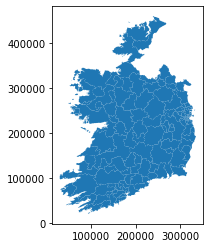

In [36]:
eircode_gdf.plot()

We can join this Eircode mapping data with the property sale volume data we prepared earlier. Doing this, we can use the Eircode mapping data to draw the plot above, and the data in the year columns to create the heatmap.

In [37]:
property_sales_volume_animation_data = eircode_gdf.join(property_sale_volumes)
property_sales_volume_animation_data.head()

Descriptor                                           geometry  \
RoutingKey                                                                    
A41         BALLYBOUGHAL  POLYGON Z ((315955.386 256978.846 0.000, 31648...   
A45              OLDTOWN  POLYGON Z ((314571.090 253236.195 0.000, 31454...   
A67              WICKLOW  POLYGON Z ((334558.591 192357.530 0.000, 33452...   
A83              ENFIELD  POLYGON Z ((289532.317 249779.205 0.000, 28942...   
A91              DUNDALK  POLYGON Z ((288753.376 303794.647 0.000, 28886...   

             2010  2011  2012  2013   2014   2015   2016   2017   2018   2019  \
RoutingKey                                                                      
A41           1.0   3.0   0.0   3.0    0.0    0.0    7.0    5.0    2.0    9.0   
A45           4.0   4.0   2.0   1.0    3.0    2.0    1.0    5.0    2.0    1.0   
A67          42.0  20.0  34.0  38.0   40.0   63.0   52.0   85.0   92.0  161.0   
A83          41.0  14.0  20.0  13.0   17.0   20.0   22.0   46.0   29.0   28.0   
A91         134.0  79.0  80.0  90.0  143.0  136.0  141.0  161.0  212.0  213.0   

             2020  
RoutingKey         
A41           4.0  
A45           1.0  
A67         158.0  
A83          42.0  
A91         183.0

And create an animation, as below.

In [50]:
# Function for creating heatmaps 
def heatmap_animation(animation_data, frames, title, cmap=None):
    
    # Base plot, axes, and legend
    fig = plt.figure(figsize=(11,11)) 
    ax = fig.add_subplot(1,1,1)
    fig.colorbar(plt.cm.ScalarMappable(cmap=cmap))

    # Calculate the largest areas to provide a label, to give us some context as to where the regions are
    largest_areas = animation_data.loc[animation_data['geometry'].area.sort_values(ascending=False)[:10].index]

    # Main animation function – update plot for each year
    def update(frame):
        ax.clear() # Clear plot

        # Axis styling
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])

        # Update plot
        animation_data.plot(ax=ax,column=str(frame),cmap=cmap)
        ax.set_title(f"{title} – {frame}")
        
        # Draw some labels if the number of elements is small enough, for context
        if animation_data.index.size < 50:
                # Apply label to largest regions
            largest_areas.apply(lambda x: \
                                ax.annotate(text=x.Descriptor, 
                                            xy=x.geometry.centroid.coords[0], 
                                            ha='center'), 
                                axis=1);


    ani = FuncAnimation(fig, update, frames=frames, interval=1000)

    plt.close() # prevents a second, static plot from being rendered

    return ani.to_jshtml()

In [51]:
frames = list(range(2010,2021,1)) # Frames in the animation, 1 per year
title = "Property sales volume"
HTML(heatmap_animation(property_sales_volume_animation_data, frames, title))

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


<Figure size 432x288 with 0 Axes>

Going through the animation, we can see property sales are concentrated at our largest towns and cities, as expected. We see a bit of a lull in sales and less sales in rural Eircodes relative to urban Eircodes in 2016-17. The mortgage lending restrictions were introduced in 2015, so potentially this lull could be related to less mortgages being approved and people needed to save for a deposit. This is speculation though, and more research would be required.

What I want to look at for our analysis, is in 2018 through 2020, we start seeing a surge in property sales in the Greater Dublin Area. It's clear that people are purchasing property in the areas surrounding the city. So let's look at housing affordability in the Greater Dublin Area.

We first need to identify Eircodes in the Greate Dublin Area. To do this, I used Dublin 2 as a central point and retrieved a list of the closest Eircodes using their coordinates.

In [52]:
# Taking Dublin 2 as the centroid
dub2_centroid = eircode_gdf.loc['D02'].geometry.centroid

# Get the top 45 closest Eircode regions
greater_dublin_area = eircode_gdf.loc[eircode_gdf.distance(dub2_centroid).sort_values()[:45].index]
greater_dublin_area # Show the Eircodes we have selected for the Greater Dublin Area

Descriptor                                           geometry
RoutingKey                                                                 
D02             DUBLIN 2  POLYGON Z ((316406.299 232692.061 0.000, 31630...
D04             DUBLIN 4  POLYGON Z ((318058.088 230181.929 0.000, 31774...
D01             DUBLIN 1  POLYGON Z ((315865.141 235967.450 0.000, 31588...
D08             DUBLIN 8  POLYGON Z ((311557.102 233636.908 0.000, 31162...
D06             DUBLIN 6  POLYGON Z ((316798.623 232200.126 0.000, 31678...
D07             DUBLIN 7  POLYGON Z ((315775.283 235787.510 0.000, 31578...
D03             DUBLIN 3  MULTIPOLYGON Z (((322038.701 237170.946 0.000,...
D6W            DUBLIN 6W  POLYGON Z ((314889.328 232273.184 0.000, 31486...
D12            DUBLIN 12  POLYGON Z ((314817.815 232184.464 0.000, 31480...
D09             DUBLIN 9  POLYGON Z ((317758.492 236958.342 0.000, 31773...
D11            DUBLIN 11  POLYGON Z ((315555.407 239740.395 0.000, 31553...
D14            DUBLIN 14  POLYGON Z ((318988.354 227956.658 0.000, 31884...
A94            BLACKROCK  POLYGON Z ((320410.336 226403.233 0.000, 32034...
D05             DUBLIN 5  POLYGON Z ((320223.973 239303.306 0.000, 32035...
D10            DUBLIN 10  POLYGON Z ((312024.734 233750.090 0.000, 31201...
D20            DUBLIN 20  POLYGON Z ((310726.906 233812.598 0.000, 31075...
D15            DUBLIN 15  POLYGON Z ((312537.905 237434.775 0.000, 31251...
D16            DUBLIN 16  POLYGON Z ((313163.732 227939.176 0.000, 31328...
D17            DUBLIN 17  POLYGON Z ((321276.916 243133.377 0.000, 32143...
D22            DUBLIN 22  POLYGON Z ((302709.311 231227.966 0.000, 30270...
D13            DUBLIN 13  MULTIPOLYGON Z (((320660.270 240073.842 0.000,...
D18            DUBLIN 18  POLYGON Z ((323006.422 225462.967 0.000, 32303...
D24            DUBLIN 24  POLYGON Z ((313277.262 220663.337 0.000, 31309...
K67               SWORDS  POLYGON Z ((320884.534 243320.168 0.000, 32087...
A96           GLENAGEARY  POLYGON Z ((322754.600 226757.223 0.000, 32284...
K78                LUCAN  POLYGON Z ((306339.583 234882.738 0.000, 30631...
K36             MALAHIDE  MULTIPOLYGON Z (((326409.353 250573.395 0.000,...
A98                 BRAY  POLYGON Z ((328969.187 215595.806 0.000, 32887...
W23             MAYNOOTH  POLYGON Z ((302157.472 235765.027 0.000, 30210...
A86             DUNBOYNE  POLYGON Z ((303605.412 247010.664 0.000, 30366...
A41         BALLYBOUGHAL  POLYGON Z ((315955.386 256978.846 0.000, 31648...
A84            ASHBOURNE  POLYGON Z ((301863.014 259932.719 0.000, 30213...
A45              OLDTOWN  POLYGON Z ((314571.090 253236.195 0.000, 31454...
K45                 LUSK  POLYGON Z ((315748.344 257740.112 0.000, 31586...
W91                 NAAS  POLYGON Z ((312888.848 211057.885 0.000, 31231...
A85         DUNSHAUGHLIN  POLYGON Z ((305755.254 249813.449 0.000, 30564...
K56                 RUSH  MULTIPOLYGON Z (((323682.886 253392.302 0.000,...
A63           GREYSTONES  POLYGON Z ((327981.720 214568.061 0.000, 32785...
K32           BALBRIGGAN  POLYGON Z ((323099.612 260611.965 0.000, 32302...
A42           GARRISTOWN  POLYGON Z ((302973.044 262247.099 0.000, 30367...
K34             SKERRIES  POLYGON Z ((327545.555 256268.636 0.000, 32749...
C15                NAVAN  POLYGON Z ((304086.110 263307.579 0.000, 30367...
A83              ENFIELD  POLYGON Z ((289532.317 249779.205 0.000, 28942...
A92             DROGHEDA  POLYGON Z ((307883.798 265820.141 0.000, 30784...
A67              WICKLOW  POLYGON Z ((334558.591 192357.530 0.000, 33452...

With a list of Greate Dublin Area Eircodes, we can create a plot similar to before, but this time only showing the selected Eircodes. I also added some code to the animation function to draw labels on the largest regions to give us some context as to what we're looking at.

In [53]:
gda_sales_volume_animation_data = greater_dublin_area.join(property_sale_volumes)
frames = list(range(2010,2021,1)) # Frames in the animation, 1 per year
title = "Property sales volume GDA"
HTML(heatmap_animation(gda_sales_volume_animation_data, frames, title))

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


<Figure size 432x288 with 0 Axes>

### Discussion

We can see in this plot that sales were more balanced across the region at the beginning of the decade, with a larger disparity emerging towards the end of the decade where we see a noticeable increase in property sales in more peripheral locations such as Maynooth, Naas, and Drogheda, and noticeably less closer to the city. For context, for people living in these regions and commuting to Dublin as many people do, they can face a commute of over an hour each way. This is not a sustainable way to expand a city, and it's leading to urban sprawl.

Dublin 15 is the standout region where the most people are purchasing property in each year. This can be attributed to the quantity of new properties being built in that region.

## Greater Dublin Area property affordability

We've now seen where people are buying property, let's now look at how affordable each area is and how that's changed over time, which might explain why people are buying property where they are. To do this, we will compare each regions median property price over time with Dublin's median earnings.

We only have earnings data up until 2018, so for this analysis I will project the change in median earnings. To do this, I am assuming a 2% year on year increase. Some data sources show the average wage jumped significantly (https://www.cso.ie/en/statistics/earnings/earningsandlabourcosts/). This could be skewed high so I'm hesitant to adopt it, but I believe it's reasonably safe to speculate that median earnings increased.

In [54]:
annual_earnings_median_dublin_projection = annual_earnings_median_dublin.copy()
annual_earnings_median_dublin_projection.loc['2019'] = annual_earnings_median_dublin_projection.loc['2018']*1.02
annual_earnings_median_dublin_projection.loc['2020'] = annual_earnings_median_dublin_projection.loc['2019']*1.02
annual_earnings_median_dublin_projection.tail() # Example of what our projection looks like

Median Earnings  Individual mortgage – 3.5x  Individual mortgage – 4.5x  \
Year                                                                            
2016       37084.0000                 129794.0000                 166878.0000   
2017       38067.0000                 133234.5000                 171301.5000   
2018       39408.0000                 137928.0000                 177336.0000   
2019       40196.1600                 140686.5600                 180882.7200   
2020       41000.0832                 143500.2912                 184500.3744   

      Couple mortgage – 3.5x  Couple mortgage – 4.5x  
Year                                                  
2016             259588.0000             333756.0000  
2017             266469.0000             342603.0000  
2018             275856.0000             354672.0000  
2019             281373.1200             361765.4400  
2020             287000.5824             369000.7488

To visualise regions based on how affordable they are, I wanted to visualise how the regions compare to the against the lower and higher mortgage limit. As reasoned earlier, if prices are pushing or above the upper limit we can regard them as not really affordable. If they are around or lower than the lower limit, they're at a reasonable level.

I decided to normalise the house prices against a couples lending potential, and clip the values at 0 and 1. That is, anything that is less than the 3.5x lending limit would be 0, anything above the 4.5x limt would be 1. I did this because, for this analysis, it doesn't matter how cheap a region is once it's affordable. Alternatively it doesn't matter how expensive a region is if it's not affordable, it's already out of the question. This system allows us to easily visualise the range of regions in the middle, and the spread of affordability across the region.

I prepared the property sales data I used earlier, and combined it with the Greater Dublin Area Eircodes.

In [57]:
# Filter out 'All' Eircode data and format to 3 character region key
eircode_property_prices = property_sale_prices[property_sale_prices['Eircode Output'] != 'All'].copy()
eircode_property_prices['Eircode Output'] = eircode_property_prices['Eircode Output'].str[:3]
eircode_property_prices = eircode_property_prices.pivot(index='Eircode Output', columns=['Year'], values='Median property value')

# Fill NaN values with the median value for that region. 
# Unlikely to be an issue with our visualisation as this is Eircodes with no property sales recorded for that year
eircode_property_prices = eircode_property_prices.T.fillna(eircode_property_prices.median(axis=1)).T 
eircode_property_prices = eircode_property_prices.drop(['2010'], axis=1) # We have no earnings data for 2010

# Normalise the property prices around our earnings data
normalised_prices = (eircode_property_prices.sub(annual_earnings_median_dublin_projection['Couple mortgage – 3.5x'], axis=1))/(annual_earnings_median_dublin_projection['Couple mortgage – 4.5x']-annual_earnings_median_dublin_projection['Couple mortgage – 3.5x'])
# Then clip the data at 0 and 1. i.e. anything over 1 we round to 1. 
# This let's us visualise regions which have exceeded our upper limit clearly.
eircode_property_prices = normalised_prices.clip(0,1)

# Inner join with Greater Dublin Area Eircodes
gda_property_prices = eircode_property_prices.join(greater_dublin_area, on='Eircode Output', how='inner')

# Turn into a GeoDataFrame for easier plotting
gda_property_prices = gpd.GeoDataFrame(gda_property_prices) 
gda_property_prices.head()


2011     2012  2013  2014      2015      2016      2017  \
Eircode Output                                                                
A41             0.055269  1.00000   1.0   1.0  1.000000  1.000000  1.000000   
A42             0.000000  0.00000   0.0   0.0  0.000000  0.173923  0.842317   
A45             0.000000  1.00000   0.0   0.0  0.000000  1.000000  0.269669   
A63             0.055269  0.10587   0.0   0.0  0.126112  0.072969  0.611159   
A67             0.000000  0.00000   0.0   0.0  0.000000  0.005555  0.177726   

                2018      2019      2020    Descriptor  \
Eircode Output                                           
A41              1.0  1.000000  1.000000  BALLYBOUGHAL   
A42              1.0  0.293895  0.066761    GARRISTOWN   
A45              0.0  0.000000  1.000000       OLDTOWN   
A63              1.0  1.000000  1.000000    GREYSTONES   
A67              0.0  0.169505  0.463407       WICKLOW   

                                                         geometry  
Eircode Output                                                     
A41             POLYGON Z ((315955.386 256978.846 0.000, 31648...  
A42             POLYGON Z ((302973.044 262247.099 0.000, 30367...  
A45             POLYGON Z ((314571.090 253236.195 0.000, 31454...  
A63             POLYGON Z ((327981.720 214568.061 0.000, 32785...  
A67             POLYGON Z ((334558.591 192357.530 0.000, 33452...

In [58]:
frames = list(range(2011,2021,1))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])
title = "Greater Dublin Area affordability"
HTML(heatmap_animation(gda_property_prices, frames, title, cmap))

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


<Figure size 432x288 with 0 Axes>

### Discussion

From our animation we can see the change in property affordability in the Greater Dublin Area over the past decade. Regions in dark green we can deem affordable for median wage earners in Dublin, and regions in red as too expensive for most.

We see that most of the region is green to begin with, besides some areas in South Dublin which are notorious for being expensive. As we progress through the years, we quickly see the changes in housing affordability. South Dublin becomes almost entirely unaffordable, with some North Dublin regions the same. In 2017 we see the biggest jump for a lot of areas such as Naas, Maynooth, and Bray. By the end of the decade, reasonably distant commuter towns are pushing the level of affordability for the median earners from Dublin. The trend is very much people are being priced out of Dublin, and they're even starting to become priced out of the commuter towns. 

There are regions still reasonably affordable to median earners closer to the city which have not seen drastic changes in affordability. This could be attributed to poor housing stock or unattractive areas, as we can see from the sales volume animation that they don't have much sales volume either.

People will buy a house in an area for a variety of reasons – housing stock, attractive area, proximity to family or work. We cannot capture all these reasons with the data we have, but from our data it is reasonable to draw the conclusion that first-time buyers from Dublin are being priced out of the city. Sale volume is low, and prices are sky high. People from Dublin are being pushed to more peripheral regions as that's where housing is available at prices they can afford.

## Where are we building houses?

Using another dataset, we can view the housing completions by year in an Eircode. This is similar procedure to previous visualisations.

In [59]:
housing_completions_eircode = housing_completions.join(greater_dublin_area, on='Eircode Output', how='inner')
housing_completions_eircode = gpd.GeoDataFrame(housing_completions_eircode)
housing_completions_eircode.head()

2012  2013  2014   2015   2016   2017   2018   2019   2020  \
Eircode Output                                                               
A41              5.0  16.0   4.0    4.0   27.0   14.0   20.0   48.0   32.0   
A42             11.0   4.0   2.0    4.0   11.0    5.0   12.0   12.0   13.0   
A45              1.0   1.0   2.0    1.0    2.0    1.0    3.0    5.0    3.0   
A63             50.0  31.0  29.0  107.0  179.0  250.0  288.0  465.0  333.0   
A67             23.0  19.0  30.0   80.0   68.0   95.0  168.0  450.0  373.0   

                  Descriptor  \
Eircode Output                 
A41             BALLYBOUGHAL   
A42               GARRISTOWN   
A45                  OLDTOWN   
A63               GREYSTONES   
A67                  WICKLOW   

                                                         geometry  
Eircode Output                                                     
A41             POLYGON Z ((315955.386 256978.846 0.000, 31648...  
A42             POLYGON Z ((302973.044 262247.099 0.000, 30367...  
A45             POLYGON Z ((314571.090 253236.195 0.000, 31454...  
A63             POLYGON Z ((327981.720 214568.061 0.000, 32785...  
A67             POLYGON Z ((334558.591 192357.530 0.000, 33452...

In [60]:
frames = list(range(2012,2021,1))
title = "Housing completions"
HTML(heatmap_animation(housing_completions_eircode, frames, title))

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


<Figure size 432x288 with 0 Axes>

### Discussion

From this visualisation we can clearly see that supply very much correlates with sales – people are buying property wherever they can get it. Regions such as Dublin 15 which was the best sold by volume has high numbers of completed houses throughout the years, as do places like Naas and Drogheda in recent years. There's very little activity closer to the city when compared to these regions. South Dublin has little activity after 2016, which would go some way to explain the high prices and low sale volumes.

Unless more property is developed closer to the city, first-time buyers will continue to have little option but to purchase property further and further away.

## Final discussion and conclusions

Property in Ireland has become increasingly unaffordable for the median earner, especially in the Dublin region. We have seen that the price of property sold to a first-time buyer has increased drastically in recent years in comparison to earnings. Property in Dublin, Galway and Cork are maxing out borrowing limits set by the Central Bank in 2015, with the Dublin data showing that many people would already be priced out of buying property in the city. Individual borrowers are already massively priced out of the market, so we looked at how affordable housing is for a couple.

We have shown that this increase in prices is pushing people further and further from the city centre. Looking at peripheral regions in the Greater Dublin Area (GDA), there has been a noticeable uptick in property developement, sales, and prices in recent years, while new property development closer to the city is significantly less, pushing prices higher.

There is so much demand for housing, we have shown that property prices across the GDA are becoming unaffordable for the median earners. The areas with the highest number of new properties being completed are still seeing the prices rise significantly. Demand is far exceeding supply.

We are also seeing that currently it's not going to get any better any time soon. New housing being built closer to the city is minimal, not enough to satisfy demand. This could be for a variety of reasons – most likely cost of land and development.


### Further research

Some areas of interest to expand upon this might be to look at the affect the mortgage limits had on sales and prices in 2015. This would be interesting to see if the demographic of house buyers has changed, and to be able to state more clearly just how many people are being priced out of housing. There was some data available on earnings broken down by age group, unfortunately it was on a national level and not regional. If regional data was available, it would be interesting to see the shift in affordability for different age groups. Anecdotally, my parents and many of my friends parents purchased houses in their mid 20s, something almost unheard of nowadays except by extremely high earning couples.

As we have shown that housing sales are rising across the GDA, further research could be done on the impact that commuting long distances is having on this region. Are the towns being developed too, or is most business being done in far off areas? Looking at the true cost of commuter towns would also be valuable – is it cheaper to buy a cheaper house further away, but pay for a car, petrol, maintenance etc., or a more expensive house closer to work? What about savings in time spent traveling?

It is unlikely to have jumped drastically, but for part of this analysis I estimated the median earnings. Redoing this analysis when the real numbers become available would be worthwile. Additionally, the changes in housing and purchasing has increased a lot in the last few years but the last census was conducted in 2016, and 2011 prior to that. With more recent census data we would have a better understanding of the impact housing sales are having on the region. The changes since 2016 until the current day have been more drastic compared to changes in 2011 to 2016, and therefore Census 2022 will likely highlight important changes to the demographics of first-time buyers and the GDA.

We looked at the current housing market, so the next step might be to look towards the future. It's clear we need more housing closer to where people want to live, can we see if housing projects are being given planning permission? Are projects being built, and if so where and how many units? Large scale projects will take a few years to develop, so looking at this we can project, up to a point, whether things will be any different in a few years time.

Finally, this analysis only looks at the past decade due to limitations in the available data. Historical analysis might highlight further just how different the current market climate is for the current generataion of first-time buyers.